## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему.

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

In [1]:
!pip install implicit
!pip install tqdm

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import gdown
import joblib

from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv`

In [3]:
!pip3 install gdown

url_train = "https://drive.google.com/uc?id=1V6amyZU_X4LzhvfZb4oJ4s8qZ4PhKuqp"
output_train = 'train.csv'
gdown.download(url_train, output_train, quiet=False)

url_test = "https://drive.google.com/uc?id=1TaghVJeOBk9YZbRscuUhA3CwzJDtFl-c"
output_test = 'test.csv'
gdown.download(url_test, output_test, quiet=False)

url_users = "https://drive.google.com/uc?id=1zeVyP4PXik95TIR5NUnzOcHpZxDYJ7Do"
output_users = 'users.csv'
gdown.download(url_users, output_users, quiet=False)

url_items = "https://drive.google.com/uc?id=1sdbyqfynBUOv_JnnN6j61hl-9iOYeLCo"
output_items = 'items.csv'
gdown.download(url_items, output_items, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1V6amyZU_X4LzhvfZb4oJ4s8qZ4PhKuqp
From (redirected): https://drive.google.com/uc?id=1V6amyZU_X4LzhvfZb4oJ4s8qZ4PhKuqp&confirm=t&uuid=142cf19c-20db-413a-be72-48a12479af5b
To: /content/train.csv
100%|██████████| 170M/170M [00:01<00:00, 97.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TaghVJeOBk9YZbRscuUhA3CwzJDtFl-c
To: /content/test.csv
100%|██████████| 21.1M/21.1M [00:00<00:00, 94.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zeVyP4PXik95TIR5NUnzOcHpZxDYJ7Do
To: /content/users.csv
100%|██████████| 29.9M/29.9M [00:00<00:00, 51.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sdbyqfynBUOv_JnnN6j61hl-9iOYeLCo
To: /content/items.csv
100%|██████████| 31.8M/31.8M [00:00<00:00, 51.4MB/s]


'items.csv'

In [4]:
pd.read_csv('users.csv')

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
...,...,...,...,...,...
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0


## 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно.

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



### Загрузка и обработка данных

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
users = pd.read_csv('users.csv')
items = pd.read_csv('items.csv')

In [6]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Users shape:", users.shape)
print("Items shape:", items.shape)

print("\nTrain columns:", train.columns.tolist())
print("Test columns:", test.columns.tolist())
print("Users columns:", users.columns.tolist())
print("Items columns:", items.columns.tolist())

Train shape: (4866956, 6)
Test shape: (608467, 6)
Users shape: (840197, 5)
Items shape: (15963, 14)

Train columns: ['user_id', 'item_id', 'last_watch_dt', 'total_dur', 'watched_pct', 'target']
Test columns: ['user_id', 'item_id', 'last_watch_dt', 'total_dur', 'watched_pct', 'target']
Users columns: ['user_id', 'age', 'income', 'sex', 'kids_flg']
Items columns: ['item_id', 'content_type', 'title', 'title_orig', 'release_year', 'genres', 'countries', 'for_kids', 'age_rating', 'studios', 'directors', 'actors', 'description', 'keywords']


>Нам необходимо разделить `train` по времени, поэтому изменим тип данных в столбце `last_watch_dt` на `datetime`. Для `test`, также, изменим тип данных:

In [7]:
train['last_watch_dt'] = pd.to_datetime(train['last_watch_dt'])
test['last_watch_dt'] = pd.to_datetime(test['last_watch_dt'])

>Отсортируем `train` по веремени и разделим данные в пропорции 80/20:

In [8]:
train_sorted = train.sort_values('last_watch_dt').reset_index(drop=True)

In [9]:
split_date = train_sorted['last_watch_dt'].quantile(0.8)

# + 1 день для валидации, чтобы данные не пересекались
split_date_plus_1 = split_date + pd.Timedelta(days=1)

train_stage_1 = train_sorted[train_sorted['last_watch_dt'] < split_date_plus_1]
valid_stage_1 = train_sorted[train_sorted['last_watch_dt'] >= split_date_plus_1]

In [10]:
assert train_stage_1['last_watch_dt'].max() < valid_stage_1['last_watch_dt'].min()

In [11]:
print(f"train_stage_1: {train_stage_1.shape}, min date: {train_stage_1['last_watch_dt'].min()}, max date: {train_stage_1['last_watch_dt'].max()}")
print(f"valid_stage_1: {valid_stage_1.shape}, min date: {valid_stage_1['last_watch_dt'].min()}, max date: {valid_stage_1['last_watch_dt'].max()}")

train_stage_1: (3940271, 6), min date: 2021-03-13 00:00:00, max date: 2021-07-26 00:00:00
valid_stage_1: (926685, 6), min date: 2021-07-27 00:00:00, max date: 2021-08-12 00:00:00


### 1.1. Эвристическая модель (TopPop)

In [12]:
train_stage_1.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
1,841963,3095,2021-03-13,83,1.0,0
2,914523,13936,2021-03-13,5503,92.0,1
3,306374,3095,2021-03-13,2865,44.0,0
4,505923,3221,2021-03-13,12765,100.0,1


In [13]:
class TopPopRecommender:
    def __init__(self):
        self.popular_items = None
        self.max_popularity = None
        self.user_interactions = None

    def fit(self, train_df):
        item_popularity = train_df.groupby('item_id')['user_id'].count().reset_index()
        item_popularity.columns = ['item_id', 'popularity']

        self.max_popularity = item_popularity['popularity'].max()
        item_popularity['normalized_popularity'] = item_popularity['popularity'] / self.max_popularity

        self.popular_items = item_popularity.sort_values('popularity', ascending=False)

        self.user_interactions = train_df.groupby('user_id')['item_id'].apply(set).to_dict()

    def predict(self, user_id, item_id):
        if user_id in self.user_interactions and item_id in self.user_interactions[user_id]:
            return 0  # если айтем уже просмотрен, скор = 0

        if item_id in self.popular_items['item_id'].values:
            return self.popular_items.loc[self.popular_items['item_id'] == item_id, 'normalized_popularity'].values[0]
        return 0  # если айтем неизвестен, возвращаем скор 0

    def recommend(self, user_id, k=10):
        if user_id in self.user_interactions:
            viewed_items = self.user_interactions[user_id]
        else:
            viewed_items = set()

        recommended_items = [
            item for item in self.popular_items['item_id']
            if item not in viewed_items
        ]
        return recommended_items[:k]

    def recommend_all_users(self, user_ids, k=10):
        return {user_id: self.recommend(user_id, k=k) for user_id in user_ids}

In [14]:
my_heuristic_model = TopPopRecommender()
my_heuristic_model.fit(train_stage_1)

#### 1.1.1. Скор релевантности для пары user_item:

In [15]:
# топ-5 самых пополярных item-а
train_stage_1['item_id'].value_counts().head()

,count
item_id,
10440,148028
15297,144217
13865,97714
9728,84053
4151,71858


In [16]:
# пользователь и item есть в данных
user_id = 310745
item_id = 15297
score = my_heuristic_model.predict(user_id, item_id)
print(f"Скор для пользователя {user_id} и айтема {item_id}: {score:.4f}")

Скор для пользователя 310745 и айтема 15297: 0.9743


In [17]:
# item нет в данных
unknown_item_id = 99999
score = my_heuristic_model.predict(user_id, unknown_item_id)
print(f"Скор для нового айтема {unknown_item_id}: {score}")

Скор для нового айтема 99999: 0


#### 1.1.2. Top-k самых релеватных айтемов для всех пользователей:

In [18]:
train_users = train_stage_1['user_id'].unique()
valid_users = valid_stage_1['user_id'].unique()

k = 10

top_k_items = my_heuristic_model.recommend(user_id=None, k=k)  # рекомендации не зависят от user_id

train_recs = {user_id: top_k_items for user_id in train_users}
valid_recs = {user_id: top_k_items for user_id in valid_users}


print("\nРекомендации для пользователей из valid_stage_1:")
for user_id in valid_users[:5]:
    print(f"Пользователь {user_id}: {valid_recs[user_id]}")


Рекомендации для пользователей из valid_stage_1:
Пользователь 686772: [10440, 15297, 13865, 9728, 4151, 2657, 3734, 4880, 142, 6809]
Пользователь 1090560: [10440, 15297, 13865, 9728, 4151, 2657, 3734, 4880, 142, 6809]
Пользователь 600461: [10440, 15297, 13865, 9728, 4151, 2657, 3734, 4880, 142, 6809]
Пользователь 960175: [10440, 15297, 13865, 9728, 4151, 2657, 3734, 4880, 142, 6809]
Пользователь 454186: [10440, 15297, 13865, 9728, 4151, 2657, 3734, 4880, 142, 6809]


#### Вывод: модель `TopPopRecommender` реализует простую эвристику, основанную на популярности айтемов. Для всех пользователей возвращается одинаковый список топ-k популярных айтемов.

---

### 1.2. Матричная факторизация (ALS)

In [19]:
class MatrixFactorizationRecommender:
    def __init__(self, factors=50, iterations=15, regularization=0.01):
        self.model = AlternatingLeastSquares(
            factors=factors,
            iterations=iterations,
            regularization=regularization,
            random_state=42
        )
        self.user_mapping = {}
        self.item_mapping = {}
        self.sparse_matrix = None

    def _create_mappings(self, df):
        unique_users = df['user_id'].unique()
        unique_items = df['item_id'].unique()
        self.user_mapping = {user: idx for idx, user in enumerate(unique_users)}
        self.item_mapping = {item: idx for idx, item in enumerate(unique_items)}
        print(f"Количество пользователей: {len(self.user_mapping)}")
        print(f"Количество айтемов: {len(self.item_mapping)}")

    def _create_sparse_matrix(self, df):
        rows = df['user_id'].map(self.user_mapping)
        cols = df['item_id'].map(self.item_mapping)
        values = df['watched_pct']  # используем watched_pct как вес взаимодействия
        return coo_matrix((values, (rows, cols)), shape=(len(self.user_mapping), len(self.item_mapping)))

    def fit(self, train_df):
        self._create_mappings(train_df)
        self.sparse_matrix = self._create_sparse_matrix(train_df)
        self.model.fit(self.sparse_matrix)

    def predict(self, user_id, item_id):
        if user_id not in self.user_mapping or item_id not in self.item_mapping:
            return 0  # если пользователь или айтем отсутствует
        user_idx = self.user_mapping[user_id]
        item_idx = self.item_mapping[item_id]
        return self.model.user_factors[user_idx].dot(self.model.item_factors[item_idx])

    def recommend(self, user_id, k=10):
        if user_id not in self.user_mapping:
            return []  # пустой список, если пользователь отсутствует
        user_idx = self.user_mapping[user_id]

        scores = self.model.item_factors.dot(self.model.user_factors[user_idx])

        top_k_indices = np.argsort(-scores)[:k]
        return [list(self.item_mapping.keys())[idx] for idx in top_k_indices]

    def recommend_safe(self, user_id, k=10):
        if user_id not in self.user_mapping:
            return list(self.item_mapping.keys())[:k]
        return self.recommend(user_id, k=k)

    def recommend_all_users_safe(self, user_ids, k=10):
        recommendations = {}

        for user_id in tqdm(user_ids, desc="Processing users", unit="user", leave=True):
            recommendations[user_id] = self.recommend_safe(user_id, k=k)

        return recommendations

In [20]:
my_matrix_factorization = MatrixFactorizationRecommender(factors=50, iterations=15, regularization=0.01)
my_matrix_factorization.fit(train_stage_1)

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


Количество пользователей: 749415
Количество айтемов: 15009


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.2626516819000244 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

#### 1.2.1. Скор релевантности для пары user_item:

In [21]:
user_id = 310745
item_id = 13373
score = my_matrix_factorization.predict(user_id, item_id)
print(f"Скор для пользователя {user_id} и айтема {item_id}: {score}")

Скор для пользователя 310745 и айтема 13373: 0.5014926791191101


In [22]:
unknown_user_id = 999999
unknown_item_id = 888888
score = my_matrix_factorization.predict(unknown_user_id, unknown_item_id)
print(f"Скор для нового пользователя {unknown_user_id} и айтема {unknown_item_id}: {score}")

Скор для нового пользователя 999999 и айтема 888888: 0


#### 1.2.2. Top-k самых релеватных айтемов для всех пользователей:

In [23]:
train_users = train_stage_1['user_id'].unique()
valid_users = valid_stage_1['user_id'].unique()

k = 10
# train_recs = my_matrix_factorization.recommend_all_users_safe(train_users, k=k)

with open('/content/train_recs.pkl', 'rb') as f:
  train_recs = pickle.load(f)

# with open('train_recs.pkl', 'wb') as f:
#   pickle.dump(train_recs, f)

valid_users = [user_id for user_id in valid_users if user_id in my_matrix_factorization.user_mapping]
#valid_recs = my_matrix_factorization.recommend_all_users_safe(valid_users, k=k)

with open('/content/valid_recs.pkl', 'rb') as f:
  valid_recs = pickle.load(f)

# with open('valid_recs.pkl', 'wb') as f:
#   pickle.dump(valid_recs, f)

print(f"Топ-10 рекомендаций для 5-ти пользователей:")

print("\nРекомендации для пользователей из train_stage_1:")
for user_id, rec_items in list(train_recs.items())[:5]:
    print(f"Пользователь {user_id}: {rec_items}")

print("\nРекомендации для пользователей из valid_stage_1:")
for user_id, rec_items in list(valid_recs.items())[:5]:
    print(f"Пользователь {user_id}: {rec_items}")

Топ-10 рекомендаций для 5-ти пользователей:

Рекомендации для пользователей из train_stage_1:
Пользователь 310745: [13373, 1115, 3808, 16488, 13545, 7789, 10879, 10876, 3632, 11494]
Пользователь 841963: [4436, 1287, 7626, 4457, 8801, 7417, 10942, 14359, 14317, 6455]
Пользователь 914523: [14901, 4774, 676, 12401, 3734, 3792, 3800, 3402, 4457, 10436]
Пользователь 306374: [7626, 15297, 12841, 4495, 12173, 8821, 1287, 3095, 8980, 7210]
Пользователь 505923: [3402, 12869, 11115, 11310, 657, 16361, 416, 6561, 16087, 14089]

Рекомендации для пользователей из valid_stage_1:
Пользователь 686772: [4457, 9728, 7571, 7107, 11778, 3076, 3734, 14359, 14476, 4436]
Пользователь 1090560: [7582, 1844, 4718, 16166, 13243, 10605, 13915, 13159, 11749, 4151]
Пользователь 600461: [11145, 8486, 14476, 15994, 15275, 12977, 10904, 651, 4151, 10440]
Пользователь 960175: [10761, 13159, 4151, 1819, 9164, 13915, 7582, 1105, 16029, 334]
Пользователь 390262: [10440, 9728, 4495, 13865, 8636, 12080, 2657, 4946, 15297, 1

#### Вывод: `матричная факторизация` учитывает индивидуальные предпочтения пользователей через латентные факторы, а также, позволяет генерировать более разнообразные рекомендации по сравнению с эвристическими моделями (например, TopPop).

---

### 1.3. Нейросетевая модель (NCF)

In [24]:
class NeuralRecommender:
    def __init__(self, num_users, num_items, embedding_dim=32, hidden_units=[64, 32], lr=0.001):
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.model = self._build_model(lr)
        self.user_mapping = {}
        self.item_mapping = {}

    def _build_model(self, lr):
        user_input = Input(shape=(1,), name="user_input")
        item_input = Input(shape=(1,), name="item_input")

        # embedding слои
        user_embedding = Embedding(input_dim=self.num_users, output_dim=self.embedding_dim, name="user_embedding")(user_input)
        item_embedding = Embedding(input_dim=self.num_items, output_dim=self.embedding_dim, name="item_embedding")(item_input)

        user_vec = Flatten()(user_embedding)
        item_vec = Flatten()(item_embedding)

        concat = Concatenate()([user_vec, item_vec])

        # полносвязные слои
        x = concat
        for units in self.hidden_units:
            x = Dense(units, activation='relu')(x)

        output = Dense(1, activation='sigmoid', name="output")(x)

        model = Model(inputs=[user_input, item_input], outputs=output)
        model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy')
        return model

    def fit(self, train_df, epochs=5, batch_size=64, callbacks=None):
        unique_users = train_df['user_id'].unique()
        unique_items = train_df['item_id'].unique()
        self.user_mapping = {user: idx for idx, user in enumerate(unique_users)}
        self.item_mapping = {item: idx for idx, item in enumerate(unique_items)}

        X_user = train_df['user_id'].map(self.user_mapping)
        X_item = train_df['item_id'].map(self.item_mapping)
        y = train_df['target']

        X_train_user, X_val_user, X_train_item, X_val_item, y_train, y_val = train_test_split(
            X_user, X_item, y, test_size=0.1, random_state=42
        )

        print("Обучение модели...")
        self.model.fit(
            [X_train_user, X_train_item], y_train,
            validation_data=([X_val_user, X_val_item], y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )

    def predict(self, user_id, item_id):
        if user_id not in self.user_mapping or item_id not in self.item_mapping:
            return 0
        user_idx = self.user_mapping[user_id]
        item_idx = self.item_mapping[item_id]

        score = self.model.predict([np.array([user_idx]), np.array([item_idx])])[0][0]
        return score

    def recommend(self, user_id, k=10):
        if user_id not in self.user_mapping:
            return []  # Пустой список, если пользователь отсутствует
        user_idx = self.user_mapping[user_id]

        all_item_indices = np.array(list(self.item_mapping.values()))
        user_indices = np.full(len(all_item_indices), user_idx)

        scores = self.model.predict([user_indices, all_item_indices]).flatten()

        top_k_indices = np.argsort(-scores)[:k]
        top_k_items = [list(self.item_mapping.keys())[idx] for idx in top_k_indices]
        return top_k_items

    def recommend_all_users_safe(self, k=10, user_batch_size=1000, max_users=None):
        all_user_indices = np.array(list(self.user_mapping.values()), dtype=np.int32)
        if max_users is not None:
            all_user_indices = all_user_indices[:max_users]

        all_item_indices = np.array(list(self.item_mapping.values()), dtype=np.int32)

        top_k_items = {}
        for i in tqdm(range(0, len(all_user_indices), user_batch_size), desc="Processing user batches"):
            batch_user_indices = all_user_indices[i:i + user_batch_size]

            user_grid, item_grid = np.meshgrid(batch_user_indices, all_item_indices, indexing='ij')
            user_grid = user_grid.flatten()
            item_grid = item_grid.flatten()

            scores = self.model.predict([user_grid, item_grid]).flatten()

            batch_score_matrix = scores.reshape((len(batch_user_indices), len(all_item_indices)))

            for user_idx, user_scores in enumerate(batch_score_matrix):
                top_k_indices = np.argsort(-user_scores)[:k]
                user_id = list(self.user_mapping.keys())[batch_user_indices[user_idx]]
                top_k_items[user_id] = [
                    {
                        "item": list(self.item_mapping.keys())[idx],
                        "score": float(user_scores[idx])
                    }
                    for idx in top_k_indices
                ]

        return top_k_items

In [25]:
# my_neural_network = NeuralRecommender(
#     num_users=train_stage_1['user_id'].nunique(),
#     num_items=train_stage_1['item_id'].nunique(),
#     embedding_dim=16,
#     hidden_units=[32, 16],
#     lr=0.001
# )

# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# train_subset = train_stage_1.sample(frac=0.1, random_state=42)  # используем 10% данных
# my_neural_network.fit(
#     train_subset,
#     epochs=5,
#     batch_size=256,
#     callbacks=[early_stopping]
# )

In [26]:
# model_path = '/content/my_neural_network.h5'
# my_neural_network.model.save(model_path)

# with open('/content/mappings.pkl', 'wb') as f:
#     pickle.dump((my_neural_network.user_mapping, my_neural_network.item_mapping), f)

In [27]:
with open('/content/mappings.pkl', 'rb') as f:
    user_mapping, item_mapping = pickle.load(f)

my_neural_network = NeuralRecommender(
    num_users=len(user_mapping),
    num_items=len(item_mapping),
    embedding_dim=16,
    hidden_units=[32, 16],
    lr=0.001
)

model_path = '/content/my_neural_network.h5'
loaded_model = load_model(model_path)
my_neural_network.model = loaded_model

my_neural_network.user_mapping = user_mapping
my_neural_network.item_mapping = item_mapping

#### 1.3.1. Скор релевантности для пары user_item:

In [28]:
known_user_id = next(iter(my_neural_network.user_mapping.keys()))
known_item_id = next(iter(my_neural_network.item_mapping.keys()))

score = my_neural_network.predict(known_user_id, known_item_id)
print(f"Скор для пользователя {known_user_id} и айтема {known_item_id}: {score}")

unknown_user_id = 999999
unknown_item_id = 888888
score = my_neural_network.predict(unknown_user_id, unknown_item_id)
print(f"Скор для нового пользователя {unknown_user_id} и айтема {unknown_item_id}: {score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Скор для пользователя 335520 и айтема 13865: 0.8044214248657227
Скор для нового пользователя 999999 и айтема 888888: 0


#### 1.3.2. Top-k самых релеватных айтемов для всех пользователей:

Найдем рекомендации для 1000 пользователей. Ограничение обусловлено тем фактом, что не хватает памяти ОЗУ и обучение для всех пользоватлей займет порядка 15 часов.

In [29]:
k = 10
max_users = 1000
# recommendations_nfs = my_neural_network.recommend_all_users_safe(k=k, max_users=max_users)

with open('/content/recommendations_nfs.pkl', 'rb') as f:
  recommendations_nfs = pickle.load(f)

# with open('recommendations_nfs.pkl', 'wb') as f:
#   pickle.dump(recommendations_nfs, f)

total_scores = []
for user_id, rec_items in recommendations_nfs.items():
    for rec in rec_items:
        total_scores.append(rec['score'])

average_score = np.mean(total_scores)
print(f"\nСредний скор для {len(total_scores)} рекомендаций: {average_score:.4f}")

print("\nТоп-10 рекомендаций для первых 5 пользователей:")
for user_id, rec_items in list(recommendations_nfs.items())[:5]:
    print(f"Пользователь {user_id}: {rec_items}")


Средний скор для 10000 рекомендаций: 0.7514

Топ-10 рекомендаций для первых 5 пользователей:
Пользователь 335520: [{'item': 1554, 'score': 0.8515217304229736}, {'item': 3734, 'score': 0.8381769061088562}, {'item': 599, 'score': 0.8313813209533691}, {'item': 1508, 'score': 0.8294939398765564}, {'item': 9465, 'score': 0.8292171359062195}, {'item': 7844, 'score': 0.8213820457458496}, {'item': 1337, 'score': 0.8205468058586121}, {'item': 13622, 'score': 0.8154763579368591}, {'item': 3071, 'score': 0.8101827502250671}, {'item': 460, 'score': 0.8094466924667358}]
Пользователь 764718: [{'item': 1554, 'score': 0.7295467853546143}, {'item': 3734, 'score': 0.7144124507904053}, {'item': 599, 'score': 0.7006140947341919}, {'item': 1508, 'score': 0.698422372341156}, {'item': 9465, 'score': 0.6948202848434448}, {'item': 1337, 'score': 0.685275137424469}, {'item': 7844, 'score': 0.6838985681533813}, {'item': 13622, 'score': 0.6773854494094849}, {'item': 3071, 'score': 0.6706336736679077}, {'item': 2

#### Вывод: `NFC` строит рекомендации, используя нейронную сеть для моделирования взаимодействий между пользователями и айтемами. Модель преобразует пользователей и айтемы в эмбеддинги, объединяет их и через полносвязные слои предсказывает вероятность взаимодействия, на основе которой формируются топ-k рекомендаций.

#### ❗Скоры для всех user_item считаю в шаге 2 ❗

Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не может проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**


## 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)).

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [30]:
url_train = "https://drive.google.com/uc?id=1QpP6gzW574usSSKKsq4_FhzMH4ffaToI"
url_test = "https://drive.google.com/uc?id=1TJ32OJCix0aj3QxVLbddYmASUJ_VNlvK"

output_train = 'train_df_with_features.pkl'
output_test = 'test_df_with_features.pkl'

gdown.download(url_train, output_train, quiet=False)
gdown.download(url_test, output_test, quiet=False)

train_df_with_features = pd.read_pickle(output_train)
test_df_with_features = pd.read_pickle(output_test)

Downloading...
From (original): https://drive.google.com/uc?id=1QpP6gzW574usSSKKsq4_FhzMH4ffaToI
From (redirected): https://drive.google.com/uc?id=1QpP6gzW574usSSKKsq4_FhzMH4ffaToI&confirm=t&uuid=d791952b-2481-4d27-9bba-361fa9690524
To: /content/train_df_with_features.pkl
100%|██████████| 1.96G/1.96G [00:28<00:00, 68.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1TJ32OJCix0aj3QxVLbddYmASUJ_VNlvK
From (redirected): https://drive.google.com/uc?id=1TJ32OJCix0aj3QxVLbddYmASUJ_VNlvK&confirm=t&uuid=afb83fa5-297c-464a-8417-1c4e28c6741e
To: /content/test_df_with_features.pkl
100%|██████████| 1.21G/1.21G [00:17<00:00, 68.9MB/s]


In [31]:
def generate_features_optimized(data, train_data, items):
    user_stats = (
        train_data.groupby('user_id')
        .agg(
            avg_user_watched_pct=('watched_pct', 'mean'),  # ср. % просмотра фильмов пользователем
            total_user_watch_time=('total_dur', 'sum'),    # общее время просмотра всех фильмов пользователем
            unique_items_per_user=('item_id', 'nunique')   # кол-во уникальных фильмов, просмотренных пользователем
        )
        .reset_index()
    )

    item_stats = (
        train_data.groupby('item_id')
        .agg(
            avg_item_watched_pct=('watched_pct', 'mean'),      # ср. % просмотра фильма всеми пользователями
            unique_users_interacted=('user_id', 'nunique'),    # кол-во уникальных пользователей, взаимодействовавших с айтемом
            avg_item_watch_time=('total_dur', 'mean')          # ср. время просмотра фильма всеми пользователями
        )
        .reset_index()
    )

    # признаки за последнюю неделю
    train_data['week_ago'] = train_data['last_watch_dt'] - pd.Timedelta(days=7)
    recent_user_stats = (
        train_data[train_data['last_watch_dt'] >= train_data['week_ago']]
        .groupby('user_id')
        .agg(recent_avg_user_watched_pct=('watched_pct', 'mean'))  # ср. % просмотра фильмов пользователем за последнюю неделю
        .reset_index()
    )
    recent_item_stats = (
        train_data[train_data['last_watch_dt'] >= train_data['week_ago']]
        .groupby('item_id')
        .agg(recent_avg_item_watched_pct=('watched_pct', 'mean'))  # ср. % просмотра данного фильма за последнюю неделю
        .reset_index()
    )

    # признаки взаимодействий пользователя и айтема
    user_item_stats = (
        train_data.groupby(['user_id', 'item_id'])
        .agg(
            avg_user_item_watched_pct=('watched_pct', 'mean'),  # ср. % просмотра данного фильма данным пользователем
            total_user_item_watch_time=('total_dur', 'sum')     # общее время просмотра данного фильма данным пользователем
        )
        .reset_index()
    )

    items_exploded = items.assign(genres=items['genres'].str.split(',')).explode('genres')
    genre_stats = (
        items_exploded.groupby('genres')['item_id']
        .nunique()
        .rename('genre_popularity')
        .reset_index()
    )
    items = items.merge(genre_stats, left_on='genres', right_on='genres', how='left')

    features = data.copy()
    features = features.merge(user_stats, on='user_id', how='left')
    features = features.merge(item_stats, on='item_id', how='left')
    features = features.merge(recent_user_stats, on='user_id', how='left')
    features = features.merge(recent_item_stats, on='item_id', how='left')
    features = features.merge(user_item_stats, on=['user_id', 'item_id'], how='left')
    features = features.merge(items[['item_id', 'genres', 'genre_popularity']], on='item_id', how='left')
    features.fillna(0, inplace=True)

    return features

In [32]:
# train_df_with_features = generate_features_optimized(valid_stage_1, train, items)
# test_df_with_features = generate_features_optimized(test, pd.concat([train, valid_stage_1]), items)

Добавим скоры как признак, т.к. не сделали это на шаге 1:

In [33]:
def add_model_scores_batched(data, top_pop_model, matrix_fact_model, neural_model, batch_size=10000):
    num_batches = int(np.ceil(len(data) / batch_size))
    data_batches = [data.iloc[i * batch_size:(i + 1) * batch_size] for i in range(num_batches)]

    results = []

    for batch_idx, batch in enumerate(data_batches):
        print(f"Обработка батча {batch_idx + 1}/{num_batches}...")
        user_ids = batch['user_id'].values
        item_ids = batch['item_id'].values

        top_pop_scores = [
            top_pop_model.predict(user_id, item_id)
            for user_id, item_id in zip(user_ids, item_ids)
        ]

        if hasattr(matrix_fact_model, 'user_mapping') and hasattr(matrix_fact_model, 'item_mapping'):
            user_indices = np.array([matrix_fact_model.user_mapping.get(uid, -1) for uid in user_ids])
            item_indices = np.array([matrix_fact_model.item_mapping.get(iid, -1) for iid in item_ids])

            valid_mask = (user_indices != -1) & (item_indices != -1)
            valid_user_indices = user_indices[valid_mask]
            valid_item_indices = item_indices[valid_mask]

            matrix_fact_scores = np.zeros(len(batch))
            if len(valid_user_indices) > 0:
                matrix_fact_scores[valid_mask] = matrix_fact_model.model.user_factors[valid_user_indices].dot(
                    matrix_fact_model.model.item_factors[valid_item_indices].T
                ).diagonal()
        else:
            raise ValueError("MatrixFactorizationRecommender должен иметь user_mapping и item_mapping.")

        if hasattr(neural_model, 'model'):
            user_indices = np.array([neural_model.user_mapping.get(uid, -1) for uid in user_ids])
            item_indices = np.array([neural_model.item_mapping.get(iid, -1) for iid in item_ids])

            valid_mask = (user_indices != -1) & (item_indices != -1)
            valid_user_indices = user_indices[valid_mask]
            valid_item_indices = item_indices[valid_mask]

            neural_scores = np.zeros(len(batch))
            if len(valid_user_indices) > 0:
                neural_scores[valid_mask] = neural_model.model.predict(
                    [valid_user_indices, valid_item_indices]
                ).flatten()
        else:
            raise ValueError("NeuralRecommender должен иметь user_mapping и item_mapping.")

        batch['top_pop_score'] = top_pop_scores
        batch['matrix_fact_score'] = matrix_fact_scores
        batch['neural_score'] = neural_scores

        results.append(batch)

    return pd.concat(results, axis=0)

In [34]:
# train_df_with_features = add_model_scores_batched(train_df_with_features, my_heuristic_model, my_matrix_factorization, my_neural_network)

Преобразуй признак `genres` с помощью OHE:

In [35]:
def encode_genres(df):
    df['genres_list'] = df['genres'].str.split(',')
    genres_dummies = df['genres_list'].explode().str.strip().str.get_dummies()

    df = pd.concat([df, genres_dummies], axis=1)
    df.drop(columns=['genres', 'genres_list'], inplace=True)
    return df

In [36]:
# train_df_with_features = encode_genres(train_df_with_features)
# test_df_with_features = encode_genres(test_df_with_features)

In [37]:
train_df_with_features.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,avg_user_watched_pct,total_user_watch_time,unique_items_per_user,avg_item_watched_pct,...,фильмы,фильмы hbo,фильмы-спектакли,фитнес,футбол,фэнтези,хочу всё знать,шоу,экранизации,юмор
0,686772,5693,2021-07-27,7078,100.0,1,84.142857,37702,7,62.402830,...,0,0,0,0,0,0,0,0,0,0
0,686772,5693,2021-07-27,7078,100.0,1,84.142857,37702,7,62.402830,...,0,0,0,0,0,0,0,0,0,0
0,686772,5693,2021-07-27,7078,100.0,1,84.142857,37702,7,62.402830,...,0,0,0,0,0,0,0,0,0,0
0,686772,5693,2021-07-27,7078,100.0,1,84.142857,37702,7,62.402830,...,0,0,0,0,0,0,0,0,0,0
1,1090560,2720,2021-07-27,1778,1.0,0,38.151515,156672,33,14.115269,...,0,0,0,0,0,0,0,0,0,0


In [38]:
test_df_with_features.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,avg_user_watched_pct,total_user_watch_time,unique_items_per_user,avg_item_watched_pct,...,фильмы,фильмы hbo,фильмы-спектакли,фитнес,футбол,фэнтези,хочу всё знать,шоу,экранизации,юмор
0,718866,6382,2021-08-13,10309,19.0,0,70.0,11803.0,2.0,22.944026,...,0,0,0,0,0,0,0,0,0,0
0,718866,6382,2021-08-13,10309,19.0,0,70.0,11803.0,2.0,22.944026,...,0,0,0,0,0,0,0,0,0,0
0,718866,6382,2021-08-13,10309,19.0,0,70.0,11803.0,2.0,22.944026,...,0,0,0,0,0,0,0,0,0,0
1,147119,13865,2021-08-13,1666,26.0,0,0.0,0.0,0.0,67.689538,...,0,0,0,0,0,0,0,0,0,0
1,147119,13865,2021-08-13,1666,26.0,0,0.0,0.0,0.0,67.689538,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# скоры для пары user_item
train_df_with_features[['top_pop_score', 'matrix_fact_score', 'neural_score']].head()

,top_pop_score,matrix_fact_score,neural_score
0,0.042634,0.002297,0.000000
0,0.042634,0.002297,0.000000
0,0.042634,0.002297,0.000000
0,0.042634,0.002297,0.000000
1,0.025752,0.494877,0.056746



## 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






### 3.1. Обучение модели

In [40]:
# !pip install --upgrade numpy scipy scikit-learn catboost

# !pip uninstall numpy scipy catboost
# !pip install numpy scipy catboost

In [41]:
from catboost import CatBoostClassifier

In [42]:
# исключаем пересекающиеся пары из тестовой выборки
train_pairs = set(zip(train_df_with_features['user_id'], train_df_with_features['item_id']))
test_pairs = set(zip(test_df_with_features['user_id'], test_df_with_features['item_id']))

intersection = test_pairs.intersection(train_pairs)

if intersection:
    print(f"Исключаем {len(intersection)} пересекающихся пар из тестовой выборки.")
    test_df_with_features = test_df_with_features[
        ~test_df_with_features.set_index(['user_id', 'item_id']).index.isin(intersection)
    ]

In [43]:
# удаляем признаки, которые напрямую связаны с таргетом и те, которые не несут смысловой нагрузки (например, id пользователя)
X_train = train_df_with_features.drop(columns=['user_id', 'item_id', 'last_watch_dt', 'target', 'watched_pct', 'avg_user_item_watched_pct'])
y_train = train_df_with_features['target']

X_test = test_df_with_features.drop(columns=['user_id', 'item_id', 'last_watch_dt', 'target', 'watched_pct', 'avg_user_item_watched_pct'])
y_test = test_df_with_features['target']

In [44]:
missing_features = set(X_train.columns) - set(X_test.columns)
extra_features = set(X_test.columns) - set(X_train.columns)

if missing_features:
    print(f"Добавляем отсутствующие признаки в тестовую выборку: {missing_features}")
    for feature in missing_features:
        X_test[feature] = 0

if extra_features:
    print(f"Удаляем лишние признаки из тестовой выборки: {extra_features}")
    X_test = X_test.drop(columns=extra_features)

X_test = X_test[X_train.columns]

Добавляем отсутствующие признаки в тестовую выборку: {'neural_score', 'караоке', 'интервью', 'matrix_fact_score', 'детские', 'top_pop_score', 'воспитание детей', 'no_genre', 'для самых маленьких'}
Удаляем лишние признаки из тестовой выборки: {'блогер', 'образование', 'токшоу', 'охота и рыбалка'}


In [45]:
# model = joblib.load('/content/model.joblib')

In [46]:
def precision_at_k(y_true, y_pred, k=10):
    precision_scores = []
    for true, pred in zip(y_true, y_pred):
        top_k_items = pred[:k]
        relevant_items = set(true)
        hits = sum(1 for item in top_k_items if item in relevant_items)
        precision_scores.append(hits / k)
    return np.mean(precision_scores)

In [47]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, use_best_model=True)

0:	test: 0.9414225	best: 0.9414225 (0)	total: 739ms	remaining: 12m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9766552931
bestIteration = 21

Shrink model to first 22 iterations.


In [48]:
all_predictions = model.predict_proba(X_test)[:, 1]
test_df_with_features['prediction'] = all_predictions

grouped = test_df_with_features.groupby('user_id')
y_true = grouped['item_id'].apply(list).tolist()

y_pred = (
    test_df_with_features
    .sort_values(['user_id', 'prediction'], ascending=[True, False])
    .groupby('user_id')['item_id']
    .apply(lambda x: x.iloc[:k].tolist())
    .tolist()
)

precision = precision_at_k(y_true, y_pred, k=k)
print(f"Precision@{k}: {precision:.4f}")

Precision@10: 0.4892


#### Вывод: мы удачно делаем предсказания примерно в 48% случаев.

In [49]:
# with open('model.joblib', 'wb') as f:
#     joblib.dump(model, f)

### 3.2. Важность признаков

In [50]:
import shap
import matplotlib.pyplot as plt

Топ-10 самых важных признаков:
                     Feature Id  Importances
0    total_user_item_watch_time    35.200832
1                     total_dur    20.755710
2           avg_item_watch_time    20.640990
3          avg_item_watched_pct    10.434691
4   recent_avg_item_watched_pct     7.230928
5         unique_items_per_user     2.214650
6          avg_user_watched_pct     1.919619
7   recent_avg_user_watched_pct     1.602580
69                     развитие     0.000000
66                   популярное     0.000000


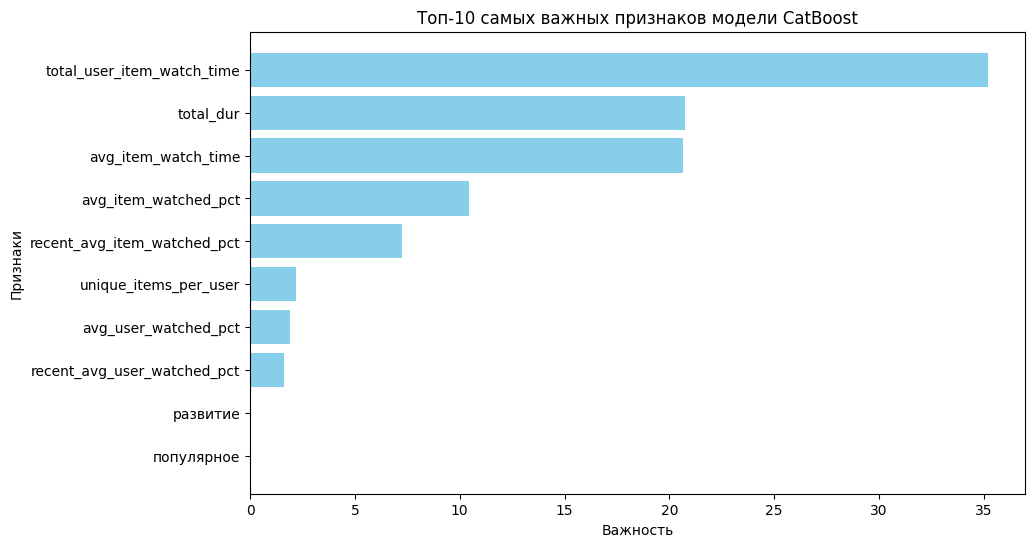

In [51]:
feature_importances = model.get_feature_importance(prettified=True)
top_10_features = feature_importances.sort_values(by='Importances', ascending=False).head(10)

print("Топ-10 самых важных признаков:")
print(top_10_features)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature Id'], top_10_features['Importances'], color='skyblue')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Топ-10 самых важных признаков модели CatBoost')
plt.gca().invert_yaxis()
plt.show()

#### Вывод: наиболее важные признаки для модели - это ср. время взаимодействия пользователя с айтемом.

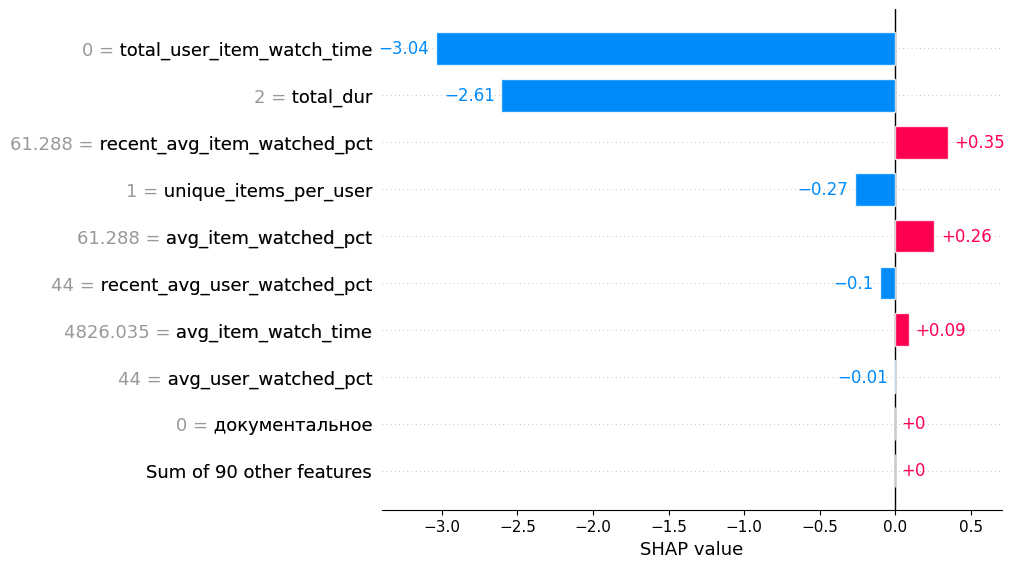

In [52]:
shap.initjs()

# SHAP-значения (на 1000 пользователях для экономии ресурсов)
X_test_sample = X_test.sample(n=1000, random_state=42)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test_sample)

sample_index = 0
shap.plots.bar(shap.Explanation(
    values=shap_values[sample_index, :],
    base_values=explainer.expected_value,
    data=X_test_sample.iloc[sample_index, :],
    feature_names=X_train.columns
))

In [53]:
# проверка наличия ликов
max_importance = feature_importances['Importances'].max()
mean_importance = feature_importances['Importances'].mean()

if max_importance > 100 * mean_importance:
    print("Есть признак с аномально высокой важностью!")
else:
    print("Все признаки имеют разумную важность.")

Все признаки имеют разумную важность.


## 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

❗Возьмем только часть данных для экономия рессурсов ❗

### 4.1. Обучение модели первого уровня на всех данных

In [54]:
all_data = pd.concat([train_stage_1, valid_stage_1, test], axis=0).reset_index(drop=True)
all_data = all_data.sample(n=1000, random_state=42).reset_index(drop=True)
all_data.shape

(1000, 6)

In [55]:
all_data.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,444789,3249,2021-07-10,418,7.0,0
1,234818,2172,2021-03-24,2230,39.0,0
2,894714,6449,2021-06-02,4198,58.0,1
3,682235,5405,2021-06-05,688,10.0,0
4,474139,8784,2021-05-15,5853,2.0,0


In [56]:
all_data['last_watch_dt'] = pd.to_datetime(all_data['last_watch_dt'])

In [57]:
# эвристическая модель
heuristic_model_all = TopPopRecommender()
heuristic_model_all.fit(all_data)

In [58]:
# ALS
matrix_factorization_all = MatrixFactorizationRecommender(factors=50, iterations=15, regularization=0.01)
matrix_factorization_all.fit(all_data)

Количество пользователей: 996
Количество айтемов: 595


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0033235549926757812 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

In [59]:
# NFC
neural_network_all = NeuralRecommender(
    num_users=train_stage_1['user_id'].nunique(),
    num_items=train_stage_1['item_id'].nunique(),
    embedding_dim=16,
    hidden_units=[32, 16],
    lr=0.001
)

neural_network_all.fit(all_data)

Обучение модели...
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 0.6927 - val_loss: 0.6898
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - loss: 0.6839 - val_loss: 0.6874
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 0.6776 - val_loss: 0.6848
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - loss: 0.6628 - val_loss: 0.6824
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - loss: 0.6331 - val_loss: 0.6812


### 4.2. Генерация N кандидатов для каждой модели первого уровня для каждого пользователя

In [60]:
N = 10  # кол-во кандидатов для каждого пользователя

all_users = all_data['user_id'].unique()

# сохраняем рекомендации
recommendations = {
    'heuristic': {},
    'als': {},
    'neural': {}
}

recommendations_list = []

In [61]:
print("Генерация кандидатов для эвристической модели...")
for user_id in all_users:
    recommendations['heuristic'][user_id] = heuristic_model_all.recommend(user_id, N)

Генерация кандидатов для эвристической модели...


In [62]:
print("Генерация кандидатов для ALS...")
recommendations['als'] = matrix_factorization_all.recommend_all_users_safe(all_users, k=N)

Генерация кандидатов для ALS...


Processing users: 100%|██████████| 996/996 [00:00<00:00, 4704.23user/s]


In [63]:
print("Генерация кандидатов для нейронной сети...")
for user_id in all_users:
    recommendations['neural'][user_id] = neural_network_all.recommend(user_id, k=N)

Генерация кандидатов для нейронной сети...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

In [64]:
for model_name, user_recommendations in recommendations.items():
    for user_id, items in user_recommendations.items():
        for rank, item_id in enumerate(items, start=1):
            recommendations_list.append({
                'model': model_name,
                'user_id': user_id,
                'item_id': item_id,
                'rank': rank
            })

recommendations_df = pd.DataFrame(recommendations_list)

In [65]:
recommendations_df.head()

,model,user_id,item_id,rank
0,heuristic,444789,15297,1
1,heuristic,444789,10440,2
2,heuristic,444789,9728,3
3,heuristic,444789,13865,4
4,heuristic,444789,3734,5


### 4.3. "Склеиваем" всех кандидатов для каждого пользователя (дубли удаляем), считаем скоры от всех моделей

In [73]:
unique_candidates_df = pd.DataFrame(
    [(user_id, item_id) for user_id, items in unique_candidates.items() for item_id in items],
    columns=['user_id', 'item_id']
)

print("Общее количество уникальных кандидатов:", len(unique_candidates_df))

Общее количество уникальных кандидатов: 28921


In [75]:
# user_ids = unique_candidates_df['user_id'].values
# item_ids = unique_candidates_df['item_id'].values

# heuristic_scores = [
#     heuristic_model_all.predict(user_id, item_id)
#     for user_id, item_id in tqdm(zip(user_ids, item_ids), total=len(user_ids), desc="Processing heuristic scores")
# ]

# als_scores = [
#     matrix_factorization_all.predict(user_id, item_id)
#     for user_id, item_id in tqdm(zip(user_ids, item_ids), total=len(user_ids), desc="Processing ALS scores")
# ]

# neural_scores = [
#     neural_network_all.predict(user_id, item_id)
#     for user_id, item_id in tqdm(zip(user_ids, item_ids), total=len(user_ids), desc="Processing neural scores")
# ]

# final_scores_df = unique_candidates_df.copy()
# final_scores_df['heuristic_score'] = heuristic_scores
# final_scores_df['als_score'] = als_scores
# final_scores_df['neural_score'] = neural_scores

In [ ]:
final_scores_df.head()